In [ ]:
dir_path = "./data"
dataset_name = "CommonsenseQA_test.jsonl"
# model_name = "olmo-7b-0724-instruct-hf"
model_name = "llama-3.1-8b"
dataset_path = dir_path + "/" + dataset_name
save_path = dir_path + "/" + model_name.lower()
data_ilt_path = dir_path + "/" + model_name.lower() + "/data_ilt.json"

In [ ]:
save_path

'/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.1-8b'

# 1. Consistent VS Inconsistent

## 1-1. All

[INFO] Dynamically determined interest tokens: ['A', 'B', 'C', 'D', 'E', 'ĠA', 'ĠB', 'ĠC', 'ĠD', 'ĠE']

--- 📊 Final Analysis Report for olmo-7b-0724-instruct-hf ---


## 1. Answer Token Behavior in Layers



/tmp/ipython-input-2733493900.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/olmo-7b-0724-instruct-hf/Figure/1_behavior_consistent.png'


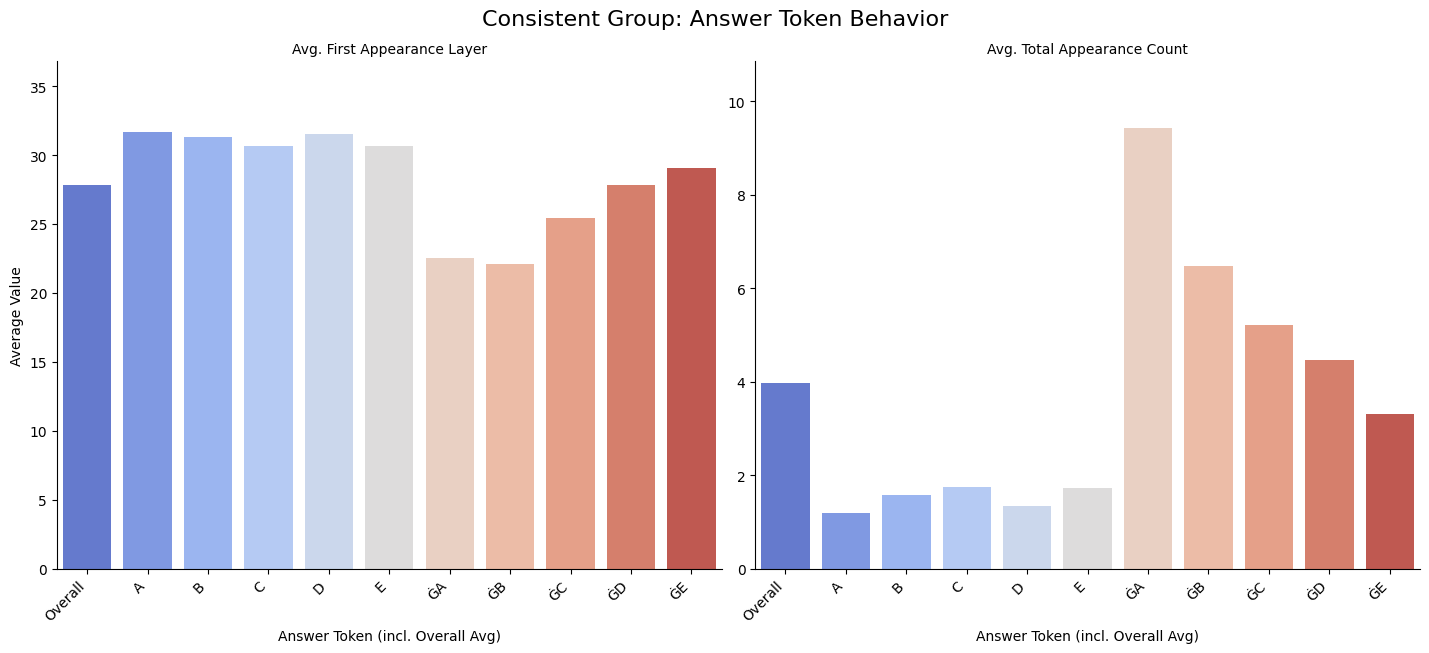

/tmp/ipython-input-2733493900.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/olmo-7b-0724-instruct-hf/Figure/1_behavior_inconsistent.png'


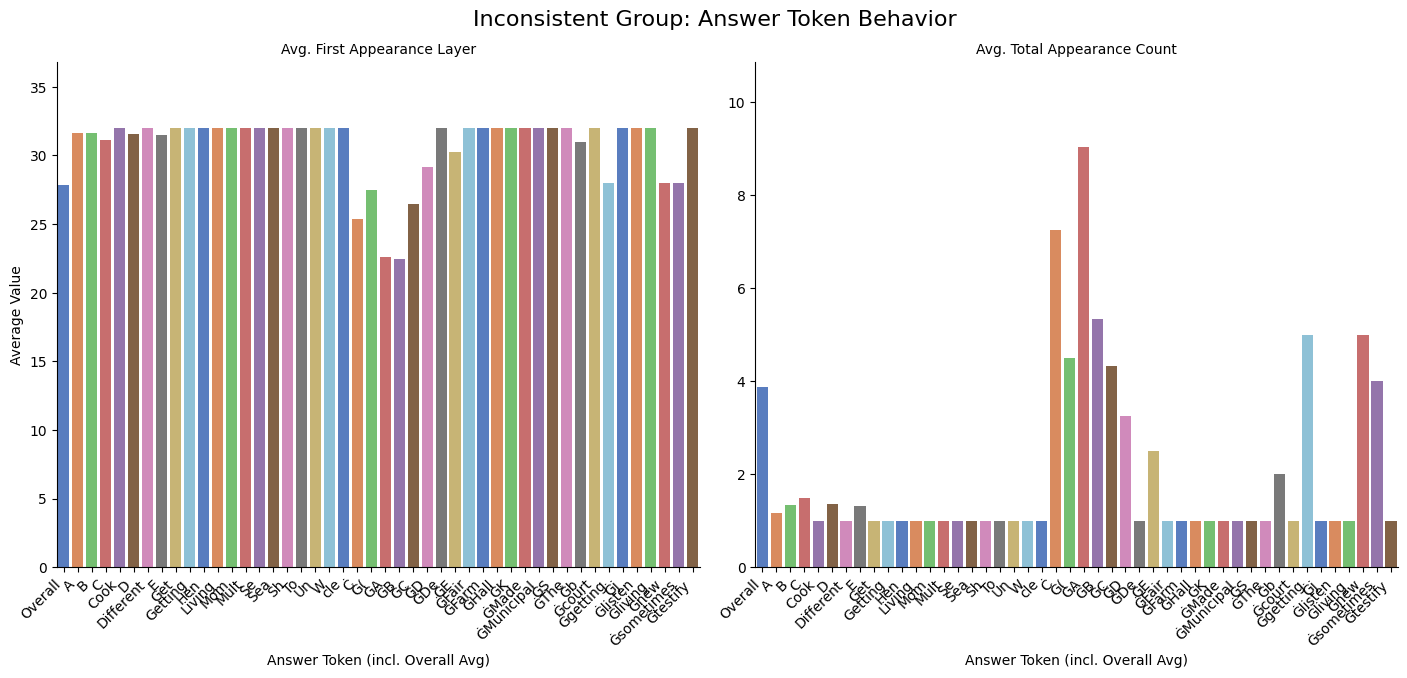

/tmp/ipython-input-2733493900.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_interest = sns.catplot(


[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/olmo-7b-0724-instruct-hf/Figure/1_behavior_inconsistent_interest_only.png'


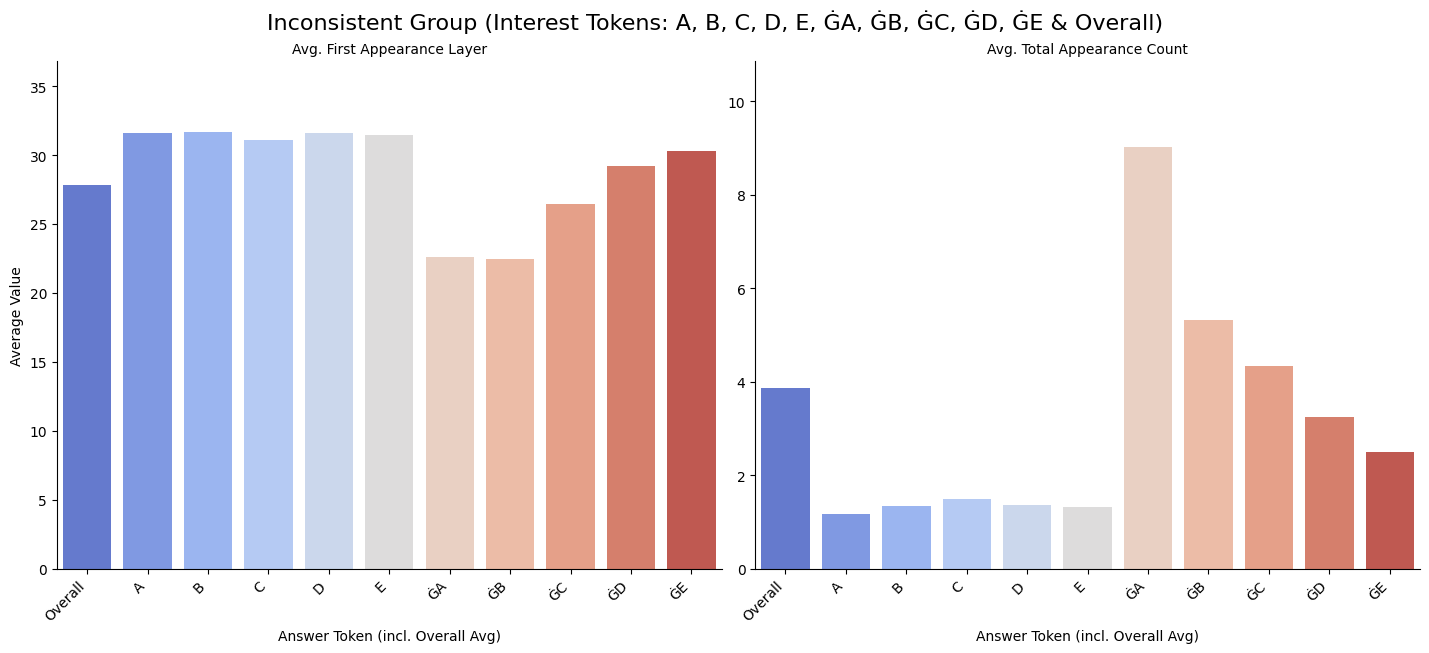



## 2. First Appearance Layer of Interest Tokens

[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/olmo-7b-0724-instruct-hf/Figure/2_interest_token_layer_distribution.png'


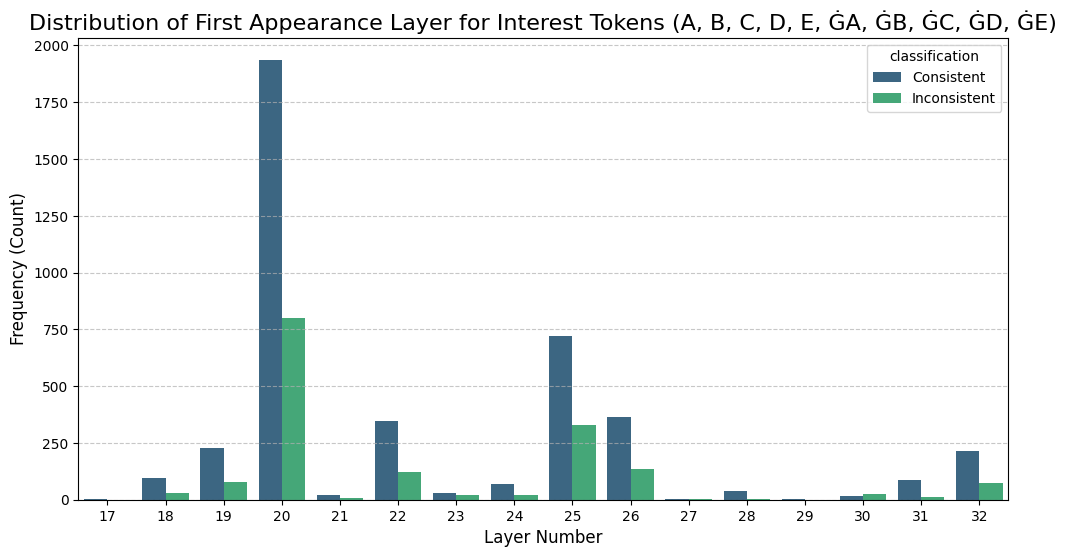



## 3. Group Distribution Comparison (Box Plots)

[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/olmo-7b-0724-instruct-hf/Figure/3_group_comparison_by_category_separated.png'


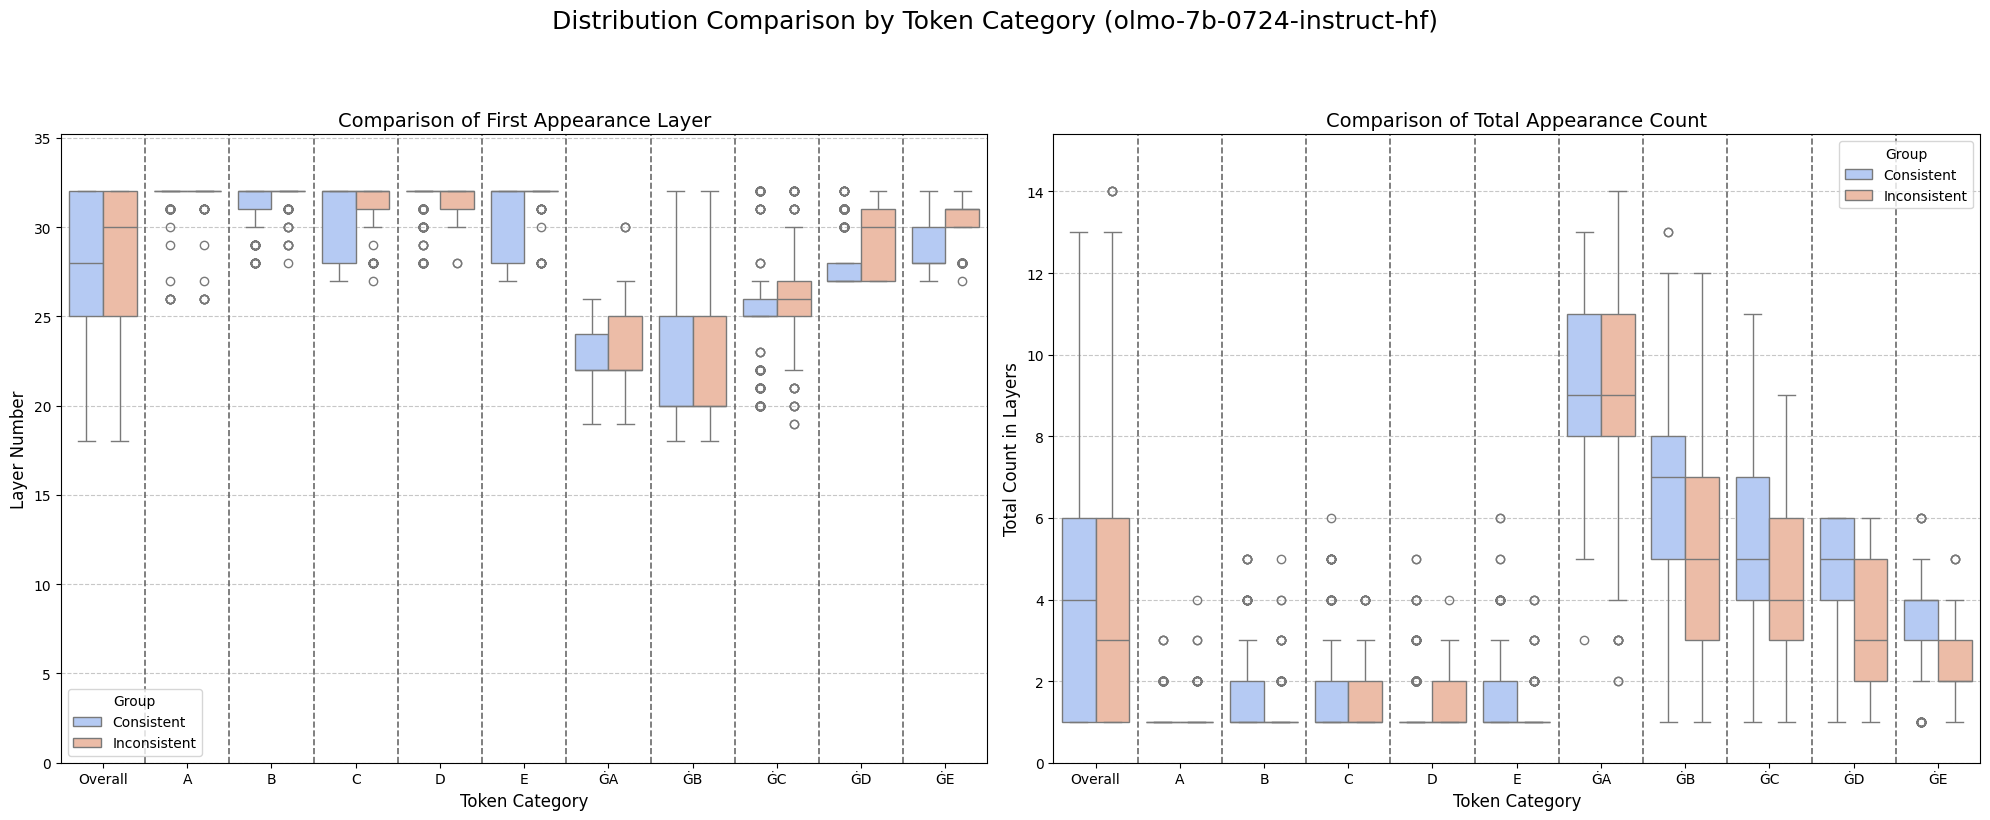

In [ ]:
import json
import pandas as pd
from typing import Dict, Any, List, Set
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# --- Helper Functions ---

def analyze_answer_token_behavior(prompt_data: Dict[str, List], target_token: str) -> Dict[str, Any]:
    """Analyzes the first appearance layer and total count of the target token."""
    layer_predictions = prompt_data.get('token', [])
    if not layer_predictions:
        return {'first_index': None, 'count': None}

    indices = [i for i, token in enumerate(layer_predictions) if token == target_token]
    count = len(indices)

    if count == 0:
        return {'first_index': None, 'count': None}

    return {'first_index': indices[0], 'count': count}

def find_first_interest_layer(layer_predictions: List[str], interest_tokens: Set[str]) -> int | None:
    """Finds the first layer where any of the interest tokens appear."""
    if not layer_predictions:
        return None
    for i, token in enumerate(layer_predictions):
        if token in interest_tokens:
            return i
    return None

# --- Visualization Functions  ---

def plot_answer_token_behavior_by_group(df: pd.DataFrame, interest_tokens: Set[str], save_dir: str):
    """Plots answer token behavior by group with consistent formatting."""
    df_plot = df.dropna(subset=['first_index', 'count'])
    if df_plot.empty: return

    stats_df = df_plot.groupby(['classification', 'target_token']).agg(
        avg_first_index=('first_index', 'mean'), avg_count=('count', 'mean')
    ).reset_index()

    overall_stats = df_plot.groupby('classification').agg(
        avg_first_index=('first_index', 'mean'), avg_count=('count', 'mean')
    ).reset_index()
    overall_stats['target_token'] = 'Overall'

    combined_stats = pd.concat([stats_df, overall_stats], ignore_index=True)

    if combined_stats.empty: return

    melted_df = combined_stats.melt(id_vars=['target_token', 'classification'], value_vars=['avg_first_index', 'avg_count'], var_name='Metric', value_name='Value')
    metric_map = {'avg_first_index': 'Avg. First Appearance Layer', 'avg_count': 'Avg. Total Appearance Count'}
    melted_df['Metric'] = melted_df['Metric'].replace(metric_map)

    max_layer_val = melted_df.loc[melted_df['Metric'] == 'Avg. First Appearance Layer', 'Value'].max()
    max_count_val = melted_df.loc[melted_df['Metric'] == 'Avg. Total Appearance Count', 'Value'].max()
    ylim_layer = (0, max_layer_val * 1.15) if pd.notna(max_layer_val) and max_layer_val > 0 else (0, 1)
    ylim_count = (0, max_count_val * 1.15) if pd.notna(max_count_val) and max_count_val > 0 else (0, 1)

    for group in ['Consistent', 'Inconsistent']:
        group_data = melted_df[melted_df['classification'] == group]
        if group_data.empty: continue

        palette_setting = 'coolwarm' if group == 'Consistent' else 'muted'
        unique_tokens = group_data['target_token'].unique()
        custom_order = ['Overall'] + sorted([t for t in unique_tokens if t != 'Overall'])

        g = sns.catplot(
            data=group_data, x='target_token', y='Value', col='Metric',
            kind='bar', palette=palette_setting, sharey=False, height=6,
            aspect=1.2, order=custom_order
        )
        g.fig.suptitle(f'{group} Group: Answer Token Behavior', y=1.03, fontsize=16)
        g.set_axis_labels("Answer Token (incl. Overall Avg)", "Average Value")
        g.set_titles(col_template="{col_name}")
        g.set_xticklabels(rotation=45, ha='right')

        for ax in g.axes.flat:
            title = ax.get_title()
            if 'Layer' in title: ax.set_ylim(ylim_layer)
            elif 'Count' in title: ax.set_ylim(ylim_count)

        filename = save_dir + f"/Figure/1_behavior_{group.lower()}.png"
        plt.savefig(filename, bbox_inches='tight')
        print(f"[INFO] Plot saved to '{filename}'")
        plt.show()
        plt.close()

        if group == 'Inconsistent' and interest_tokens:
            tokens_to_plot = interest_tokens.union({'Overall'})
            interest_data = group_data[group_data['target_token'].isin(tokens_to_plot)]

            if not interest_data.empty:
                interest_custom_order = ['Overall'] + sorted(list(interest_tokens))
                g_interest = sns.catplot(
                    data=interest_data, x='target_token', y='Value', col='Metric',
                    kind='bar', palette='coolwarm', sharey=False, height=6,
                    aspect=1.2, order=interest_custom_order
                )
                token_str = ', '.join(sorted(list(interest_tokens)))
                g_interest.fig.suptitle(f'Inconsistent Group (Interest Tokens: {token_str} & Overall)', y=1.03, fontsize=16)
                g_interest.set_axis_labels("Answer Token (incl. Overall Avg)", "Average Value")
                g_interest.set_titles(col_template="{col_name}")
                g_interest.set_xticklabels(rotation=45, ha='right')

                for ax in g_interest.axes.flat:
                    title = ax.get_title()
                    if 'Layer' in title: ax.set_ylim(ylim_layer)
                    elif 'Count' in title: ax.set_ylim(ylim_count)

                filename_interest = save_dir + "/Figure/1_behavior_inconsistent_interest_only.png"
                plt.savefig(filename_interest, bbox_inches='tight')
                print(f"[INFO] Plot saved to '{filename_interest}'")
                plt.show()
                plt.close()

def plot_interest_layer_distribution(df: pd.DataFrame, interest_tokens: Set[str], save_dir: str):
    """Visualizes the distribution of the first appearance layer for interest tokens."""
    df_plot = df.dropna(subset=['first_interest_layer']).copy()
    if df_plot.empty: return
    df_plot['first_interest_layer'] = df_plot['first_interest_layer'].astype(int)

    token_str = ', '.join(sorted(list(interest_tokens)))

    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_plot, x='first_interest_layer', hue='classification', palette='viridis', hue_order=['Consistent', 'Inconsistent'])
    plt.title(f'Distribution of First Appearance Layer for Interest Tokens ({token_str})', fontsize=16)
    plt.xlabel('Layer Number', fontsize=12)
    plt.ylabel('Frequency (Count)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    filename = save_dir + "/Figure/2_interest_token_layer_distribution.png"
    plt.savefig(filename, bbox_inches='tight')
    print(f"[INFO] Plot saved to '{filename}'")
    plt.show()
    plt.close()

def plot_group_comparison_distributions(df: pd.DataFrame, interest_tokens: Set[str], save_dir: str, model_name: str = ""):
    """Compares distributions by token categories, with vertical lines for separation."""
    df_plot = df.dropna(subset=['first_index', 'count', 'classification', 'target_token']).copy()
    if df_plot.empty or not interest_tokens:
        print("[INFO] No data or interest tokens available for group distribution comparison.")
        return

    plot_categories = sorted(list(interest_tokens))

    dfs_to_concat = []
    overall_df = df_plot.copy()
    overall_df['plot_category'] = 'Overall'
    dfs_to_concat.append(overall_df)

    for token in plot_categories:
        token_df = df_plot[df_plot['target_token'] == token].copy()
        if not token_df.empty:
            token_df['plot_category'] = token
            dfs_to_concat.append(token_df)

    plotting_df = pd.concat(dfs_to_concat, ignore_index=True)
    category_order = ['Overall'] + plot_categories

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title_str = 'Distribution Comparison by Token Category' + (f' ({model_name})' if model_name else '')
    fig.suptitle(title_str, fontsize=18, y=1.02)

    y_max_layer = df_plot['first_index'].max()
    y_max_count = df_plot['count'].max()

    # Plot 1: First Appearance Layer
    sns.boxplot(ax=axes[0], data=plotting_df, x='plot_category', y='first_index', hue='classification', palette='coolwarm', order=category_order, hue_order=['Consistent', 'Inconsistent'])
    axes[0].set_title('Comparison of First Appearance Layer', fontsize=14)
    axes[0].set_xlabel('Token Category', fontsize=12)
    axes[0].set_ylabel('Layer Number', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].legend(title='Group')
    axes[0].set_ylim(0, y_max_layer * 1.1 if pd.notna(y_max_layer) and y_max_layer > 0 else 1)

    # Plot 2: Total Appearance Count
    sns.boxplot(ax=axes[1], data=plotting_df, x='plot_category', y='count', hue='classification', palette='coolwarm', order=category_order, hue_order=['Consistent', 'Inconsistent'])
    axes[1].set_title('Comparison of Total Appearance Count', fontsize=14)
    axes[1].set_xlabel('Token Category', fontsize=12)
    axes[1].set_ylabel('Total Count in Layers', fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].legend(title='Group')
    axes[1].set_ylim(0, y_max_count * 1.1 if pd.notna(y_max_count) and y_max_count > 0 else 1)

    num_categories = len(category_order)
    for ax in axes:
        for i in range(num_categories - 1):
            ax.axvline(x=i + 0.5, color='dimgray', linestyle='--', linewidth=1.2)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    filename = save_dir + "/Figure/3_group_comparison_by_category_separated.png"
    plt.savefig(filename, bbox_inches='tight')
    print(f"[INFO] Plot saved to '{filename}'")
    plt.show()
    plt.close()

# ---  Main Analysis and Output Function ---

def run_final_analysis(data: Dict[str, Any], model_name: str = "model"):
    """Runs all analyses with dynamic token handling and outputs results."""

    results = []
    for group_id, group_data in data.items():
        answers = group_data.get('answers', [])
        if not answers: continue

        normalized_answers = [ans.lstrip('Ġ_ ') for ans in answers]
        is_consistent = len(set(normalized_answers)) == 1
        classification = 'Consistent' if is_consistent else 'Inconsistent'

        for i in range(len(answers)):
            prompt_key = f"Prompt_{i+1}"
            if prompt_key not in group_data: continue

            prompt_data = group_data[prompt_key]
            target_token = answers[i]

            behavior_metrics = analyze_answer_token_behavior(prompt_data, target_token)

            results.append({
                'classification': classification,
                'target_token': target_token,
                'first_index': behavior_metrics['first_index'],
                'count': behavior_metrics['count'],
                'layer_predictions': prompt_data.get('token', [])
            })

    if not results:
        print("No data to analyze.")
        return

    df = pd.DataFrame(results)

    consistent_df = df[df['classification'] == 'Consistent']
    if not consistent_df.empty:
        interest_tokens = set(consistent_df['target_token'].unique())
        print(f"[INFO] Dynamically determined interest tokens: {sorted(list(interest_tokens))}")
    else:
        interest_tokens = set()
        print("[WARN] No 'Consistent' groups found. Interest token analysis will be skipped.")

    if interest_tokens:
        df['first_interest_layer'] = df['layer_predictions'].apply(
            lambda preds: find_first_interest_layer(preds, interest_tokens)
        )
    else:
        df['first_interest_layer'] = None

    df = df.drop(columns=['layer_predictions'])

    print("\n" + "="*80)
    print(f"--- 📊 Final Analysis Report for {model_name} ---")
    print("="*80)

    # Section 1: Answer Token Behavior
    print("\n\n## 1. Answer Token Behavior in Layers\n")
    df_base = df.dropna(subset=['first_index', 'count']).copy()
    if not df_base.empty:
        plot_answer_token_behavior_by_group(df_base, interest_tokens, save_path)
    else:
        print("No data for answer token behavior analysis.")

    # Section 2: First Appearance of Interest Tokens
    print("\n\n## 2. First Appearance Layer of Interest Tokens\n")
    if interest_tokens:
        df_interest = df.dropna(subset=['first_interest_layer']).copy()
        if not df_interest.empty:
            plot_interest_layer_distribution(df_interest, interest_tokens, save_path)
        else:
            print("Interest tokens were not found in any layer predictions.")
    else:
        print("No interest tokens were defined (no consistent groups found).")

    # Section 3: Group Distribution Comparison
    print("\n\n## 3. Group Distribution Comparison (Box Plots)\n")
    if not df_base.empty:
        plot_group_comparison_distributions(df_base, interest_tokens, save_path, model_name)
    else:
        print("Not enough data to generate group distribution comparison plots.")

    print("\n" + "="*80)

# --- Main Execution Block ---
if __name__ == '__main__':

    try:
        with open(data_ilt_path, 'r', encoding='utf-8') as f:
            json_data = json.load(f)
        run_final_analysis(json_data, model_name=model_name)
    # except FileNotFoundError:
    #     print(f"Error: '{data_ilt_path}' not found. Please check the file path and name.")
    except Exception as e:
        print(f"An error occurred: {e}")

## 1-2. Normalized

In [ ]:
import json
import os
import pandas as pd
from typing import Dict, Any, List, Set
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# --- Helper Functions ---

def balance_dataframe(df: pd.DataFrame, random_state: int = 42) -> pd.DataFrame:
    """
    Balances the data count between 'Consistent' and 'Inconsistent' groups based on the 'classification' column.
    Randomly samples from the larger group to match the size of the smaller group.

    Args:
        df (pd.DataFrame): The original DataFrame. Must include the 'classification' column.
        random_state (int): Seed value for reproducibility.

    Returns:
        pd.DataFrame: A new DataFrame where both groups have the same number of data points.
    """
    consistent_df = df[df['classification'] == 'Consistent']
    inconsistent_df = df[df['classification'] == 'Inconsistent']

    n_consistent = len(consistent_df)
    n_inconsistent = len(inconsistent_df)

    print(f"\n[INFO] Balancing data...")
    print(f"[INFO] Original counts - Consistent: {n_consistent}, Inconsistent: {n_inconsistent}")

    # If either group has no data, return the original DataFrame
    if n_consistent == 0 or n_inconsistent == 0:
        print("[WARN] One of the groups is empty. Skipping balancing.")
        return df

    # Determine the size for sampling based on the smaller group
    min_count = min(n_consistent, n_inconsistent)
    print(f"[INFO] Balancing to {min_count} samples per group.")

    # Randomly sample min_count from each group
    consistent_sampled = consistent_df.sample(n=min_count, random_state=random_state)
    inconsistent_sampled = inconsistent_df.sample(n=min_count, random_state=random_state)

    # Concatenate the sampled DataFrames and shuffle them
    balanced_df = pd.concat([consistent_sampled, inconsistent_sampled]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    print(f"[INFO] Balancing complete. Total samples: {len(balanced_df)}")
    return balanced_df

def analyze_answer_token_behavior(normalized_layer_predictions: List[str], normalized_target_token: str) -> Dict[str, Any]:
    """
    Analyzes the first appearance index and total frequency of a normalized target token
    within a list of normalized layer predictions.
    """
    if not normalized_layer_predictions:
        return {'first_index': None, 'count': None}

    # Find the indices and count of the normalized token in the normalized list.
    indices = [i for i, token in enumerate(normalized_layer_predictions) if token == normalized_target_token]
    count = len(indices)

    if count == 0:
        return {'first_index': None, 'count': None}

    return {'first_index': indices[0], 'count': count}

def find_first_interest_layer(normalized_layer_predictions: List[str], normalized_interest_tokens: Set[str]) -> int | None:
    """Finds the first layer where an interest token (normalized) appears in the normalized layer predictions."""
    if not normalized_layer_predictions:
        return None
    for i, token in enumerate(normalized_layer_predictions):
        if token in normalized_interest_tokens:
            return i
    return None

# --- Visualization Functions ---

def plot_answer_token_behavior_by_group(df: pd.DataFrame, interest_tokens: Set[str], save_dir: str):
    """Plots answer token behavior by group with consistent formatting."""
    df_plot = df.dropna(subset=['first_index', 'count']).copy()
    if df_plot.empty: return

    # Create a normalized token column for visualization before grouping.
    df_plot['normalized_token'] = df_plot['target_token'].apply(lambda t: t.strip('Ġ▁Ċ '))

    # Calculate statistics based on the normalized token.
    stats_df = df_plot.groupby(['classification', 'normalized_token']).agg(
        avg_first_index=('first_index', 'mean'),
        avg_count=('count', 'mean')
    ).reset_index()

    # Rename the column back to 'target_token' for compatibility with subsequent plot code.
    stats_df = stats_df.rename(columns={'normalized_token': 'target_token'})

    overall_stats = df_plot.groupby('classification').agg(
        avg_first_index=('first_index', 'mean'), avg_count=('count', 'mean')
    ).reset_index()
    overall_stats['target_token'] = 'Overall'

    combined_stats = pd.concat([stats_df, overall_stats], ignore_index=True)
    if combined_stats.empty: return

    melted_df = combined_stats.melt(id_vars=['target_token', 'classification'], value_vars=['avg_first_index', 'avg_count'], var_name='Metric', value_name='Value')
    metric_map = {'avg_first_index': 'Avg. First Appearance Layer', 'avg_count': 'Avg. Total Appearance Count'}
    melted_df['Metric'] = melted_df['Metric'].replace(metric_map)
    max_layer_val = melted_df.loc[melted_df['Metric'] == 'Avg. First Appearance Layer', 'Value'].max()
    max_count_val = melted_df.loc[melted_df['Metric'] == 'Avg. Total Appearance Count', 'Value'].max()
    ylim_layer = (0, max_layer_val * 1.15) if pd.notna(max_layer_val) and max_layer_val > 0 else (0, 1)
    ylim_count = (0, max_count_val * 1.15) if pd.notna(max_count_val) and max_count_val > 0 else (0, 1)

    for group in ['Consistent', 'Inconsistent']:
        group_data = melted_df[melted_df['classification'] == group]
        if group_data.empty: continue
        palette_setting = 'coolwarm' if group == 'Consistent' else 'muted'
        unique_tokens = group_data['target_token'].unique()
        custom_order = ['Overall'] + sorted([t for t in unique_tokens if t != 'Overall'])

        g = sns.catplot(data=group_data, x='target_token', y='Value', col='Metric', kind='bar', palette=palette_setting, sharey=False, height=6, aspect=1.2, order=custom_order)
        g.fig.suptitle(f'{group} Group: Answer Token Behavior (Normalized)', y=1.03, fontsize=16)
        g.set_axis_labels("Normalized Answer Token (incl. Overall Avg)", "Average Value")
        g.set_titles(col_template="{col_name}")
        g.set_xticklabels(rotation=45, ha='right')

        for ax in g.axes.flat:
            title = ax.get_title()
            if 'Layer' in title: ax.set_ylim(ylim_layer)
            elif 'Count' in title: ax.set_ylim(ylim_count)

        filename = os.path.join(save_dir, "Figure", f"normalized_1_behavior_{group.lower()}.png")
        plt.savefig(filename, bbox_inches='tight')
        print(f"[INFO] Plot saved to '{filename}'")
        plt.show()
        plt.close()

        if group == 'Inconsistent' and interest_tokens:
            tokens_to_plot = interest_tokens.union({'Overall'})
            interest_data = group_data[group_data['target_token'].isin(tokens_to_plot)]
            if not interest_data.empty:
                interest_custom_order = ['Overall'] + sorted(list(interest_tokens))
                g_interest = sns.catplot(data=interest_data, x='target_token', y='Value', col='Metric', kind='bar', palette='coolwarm', sharey=False, height=6, aspect=1.2, order=interest_custom_order)
                token_str = ', '.join(sorted(list(interest_tokens)))
                g_interest.fig.suptitle(f'Inconsistent Group (Interest Tokens: {token_str} & Overall)', y=1.03, fontsize=16)
                g_interest.set_axis_labels("Normalized Answer Token (incl. Overall Avg)", "Average Value")
                g_interest.set_titles(col_template="{col_name}")
                g_interest.set_xticklabels(rotation=45, ha='right')

                for ax in g_interest.axes.flat:
                    title = ax.get_title()
                    if 'Layer' in title: ax.set_ylim(ylim_layer)
                    elif 'Count' in title: ax.set_ylim(ylim_count)

                filename_interest = os.path.join(save_dir, "Figure", "normalized_1_behavior_inconsistent_interest_only.png")
                plt.savefig(filename_interest, bbox_inches='tight')
                print(f"[INFO] Plot saved to '{filename_interest}'")
                plt.show()
                plt.close()

def plot_interest_layer_distribution(df: pd.DataFrame, interest_tokens: Set[str], save_dir: str):
    """Visualizes the distribution of the first appearance layer for interest tokens."""
    df_plot = df.dropna(subset=['first_interest_layer']).copy()
    if df_plot.empty: return
    df_plot['first_interest_layer'] = df_plot['first_interest_layer'].astype(int)
    token_str = ', '.join(sorted(list(interest_tokens)))
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_plot, x='first_interest_layer', hue='classification', palette='viridis', hue_order=['Consistent', 'Inconsistent'])
    plt.title(f'Distribution of First Appearance Layer for Interest Tokens ({token_str})', fontsize=16)
    plt.xlabel('Layer Number', fontsize=12)
    plt.ylabel('Frequency (Count)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    filename = os.path.join(save_dir, "Figure", "normalized_2_interest_token_layer_distribution.png")
    plt.savefig(filename, bbox_inches='tight')
    print(f"[INFO] Plot saved to '{filename}'")
    plt.show(); plt.close()

def plot_group_comparison_distributions(df: pd.DataFrame, normalized_interest_tokens: Set[str], save_dir: str, model_name: str = ""):
    """Compares distributions by token categories, with vertical lines for separation."""
    df_plot = df.dropna(subset=['first_index', 'count', 'classification', 'target_token']).copy()

    if df_plot.empty or not normalized_interest_tokens:
        print("[INFO] No data or interest tokens available for group distribution comparison.")
        return

    # Create a normalized token column to define visualization categories.
    df_plot['plot_category'] = df_plot['target_token'].apply(lambda t: t.strip('Ġ_ '))

    # The categories to be displayed on the x-axis are the received 'normalized' interest tokens.
    plot_categories = sorted(list(normalized_interest_tokens))

    # Prepare 'Overall' data and 'Interest Token' data.
    dfs_to_concat = []

    # Add 'Overall' DataFrame
    overall_df = df_plot.copy()
    overall_df['plot_category'] = 'Overall'
    dfs_to_concat.append(overall_df)

    # Add 'Interest Token' DataFrame (filter based on the normalized plot_category column)
    interest_data_df = df_plot[df_plot['plot_category'].isin(plot_categories)].copy()
    dfs_to_concat.append(interest_data_df)

    # Create the final DataFrame for visualization.
    plotting_df = pd.concat(dfs_to_concat, ignore_index=True)
    category_order = ['Overall'] + plot_categories

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title_str = 'Distribution Comparison by Token Category (Normalized)' + (f' ({model_name})' if model_name else '')
    fig.suptitle(title_str, fontsize=18, y=1.02)

    y_max_layer = df_plot['first_index'].max()
    y_max_count = df_plot['count'].max()

    # Use 'plot_category' as the x-axis for plotting the Box Plot.
    sns.boxplot(ax=axes[0], data=plotting_df, x='plot_category', y='first_index', hue='classification', palette='coolwarm', order=category_order, hue_order=['Consistent', 'Inconsistent'])
    axes[0].set_title('Comparison of First Appearance Layer', fontsize=14)
    axes[0].set_xlabel('Normalized Token Category', fontsize=12); axes[0].set_ylabel('Layer Number', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7); axes[0].legend(title='Group')
    axes[0].set_ylim(0, y_max_layer * 1.1 if pd.notna(y_max_layer) and y_max_layer > 0 else 1)

    sns.boxplot(ax=axes[1], data=plotting_df, x='plot_category', y='count', hue='classification', palette='coolwarm', order=category_order, hue_order=['Consistent', 'Inconsistent'])
    axes[1].set_title('Comparison of Total Appearance Count', fontsize=14)
    axes[1].set_xlabel('Normalized Token Category', fontsize=12); axes[1].set_ylabel('Total Count in Layers', fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7); axes[1].legend(title='Group')
    axes[1].set_ylim(0, y_max_count * 1.1 if pd.notna(y_max_count) and y_max_count > 0 else 1)

    num_categories = len(category_order)
    for ax in axes:
        for i in range(num_categories - 1):
            ax.axvline(x=i + 0.5, color='dimgray', linestyle='--', linewidth=1.2)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    filename = os.path.join(save_dir, "Figure", "normalized_3_group_comparison_by_category_separated.png")
    plt.savefig(filename, bbox_inches='tight')
    print(f"[INFO] Plot saved to '{filename}'")
    plt.show(); plt.close()

# --- Main Analysis and Output Function ---

def run_final_analysis(data: Dict[str, Any], save_dir: str, model_name: str = "model"):
    """
    Runs the analysis using normalization for all layer predictions and answers,
    then outputs the results.
    """

    # Normalization function
    def normalize_token(token: str) -> str:
        return token.strip('Ġ▁Ċ ')

    results = []
    for group_id, group_data in data.items():
        answers = group_data.get('answers', [])
        if not answers: continue

        # 1. Normalization for judging answer consistency
        normalized_answers = [normalize_token(ans) for ans in answers]
        is_consistent = len(set(normalized_answers)) == 1
        classification = 'Consistent' if is_consistent else 'Inconsistent'

        for i in range(len(answers)):
            prompt_key = f"Prompt_{i+1}"
            if prompt_key not in group_data: continue

            prompt_data = group_data[prompt_key]
            raw_target_token = answers[i]
            raw_layer_predictions = prompt_data.get('token', [])

            # 2. Normalize Layer Predictions and Target Token
            normalized_target_token = normalize_token(raw_target_token)
            normalized_layer_predictions = [normalize_token(p) for p in raw_layer_predictions]

            # 3. Call analysis function with normalized data
            behavior_metrics = analyze_answer_token_behavior(normalized_layer_predictions, normalized_target_token)

            results.append({
                'classification': classification,
                'target_token': raw_target_token,  # Store original token for visualization
                'first_index': behavior_metrics['first_index'],
                'count': behavior_metrics['count'],
                'layer_predictions': raw_layer_predictions # Temporarily store original predictions
            })

    if not results:
        print("No data to analyze.")
        return

    df = pd.DataFrame(results)

    # df = balance_dataframe(df)

    # 4. Determine and print Interest Tokens based on normalized tokens
    df['normalized_target_token'] = df['target_token'].apply(normalize_token)
    consistent_df = df[df['classification'] == 'Consistent']

    if not consistent_df.empty:
        # Create the set of interest_tokens from normalized tokens (this is the sole criterion)
        interest_tokens = set(consistent_df['normalized_target_token'].unique())

        # Display the list of normalized interest tokens.
        print(f"[INFO] Dynamically determined interest tokens: {sorted(list(interest_tokens))}")

    else:
        interest_tokens = set()
        print("[WARN] No 'Consistent' groups found. Interest token analysis will be skipped.")

    # 5. Calculate First Interest Layer based on normalized Layer predictions
    if interest_tokens:
        df['first_interest_layer'] = df['layer_predictions'].apply(
            lambda preds: find_first_interest_layer([normalize_token(p) for p in preds], interest_tokens)
        )
    else:
        df['first_interest_layer'] = None

    # Remove temporary columns
    df = df.drop(columns=['layer_predictions', 'normalized_target_token'])

    # --- Print Report ---
    print("\n" + "="*80)
    print(f"--- 📊 Final Analysis Report for {model_name} (Normalized) ---")
    print("="*80)

    print("\n\n## 1. Answer Token Behavior in Layers\n")
    df_base = df.dropna(subset=['first_index', 'count']).copy()
    if not df_base.empty:
        # Table printing code is omitted, call plot function
        plot_answer_token_behavior_by_group(df_base, interest_tokens, save_dir)
    else:
        print("No data for answer token behavior analysis.")

    print("\n\n## 2. First Appearance Layer of Interest Tokens\n")
    if interest_tokens:
        df_interest = df.dropna(subset=['first_interest_layer']).copy()
        if not df_interest.empty:
            # Table printing code is omitted, call plot function
            plot_interest_layer_distribution(df_interest, interest_tokens, save_dir)
        else:
            print("Interest tokens were not found in any layer predictions.")
    else:
        print("No interest tokens were defined (no consistent groups found).")

    print("\n\n## 3. Group Distribution Comparison (Box Plots)\n")
    if not df_base.empty:
        plot_group_comparison_distributions(df_base, interest_tokens, save_dir, model_name)
    else:
        print("Not enough data to generate group distribution comparison plots.")
    print("\n" + "="*80)

[INFO] Dynamically determined interest tokens: ['A', 'B', 'C', 'D', 'E']

--- 📊 Final Analysis Report for llama-3.1-8b (Normalized) ---


## 1. Answer Token Behavior in Layers



/tmp/ipython-input-4221016300.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=group_data, x='target_token', y='Value', col='Metric', kind='bar', palette=palette_setting, sharey=False, height=6, aspect=1.2, order=custom_order)


[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.1-8b/Figure/normalized_1_behavior_consistent.png'


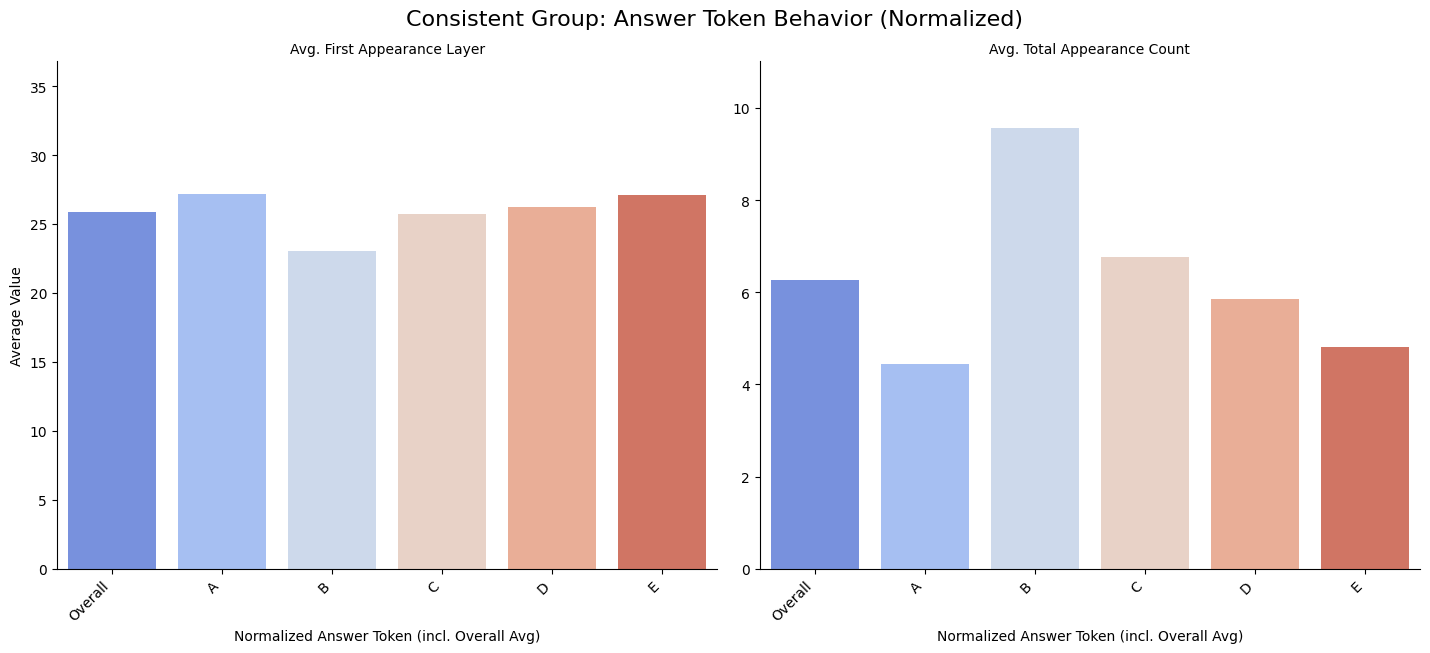

/tmp/ipython-input-4221016300.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=group_data, x='target_token', y='Value', col='Metric', kind='bar', palette=palette_setting, sharey=False, height=6, aspect=1.2, order=custom_order)


[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.1-8b/Figure/normalized_1_behavior_inconsistent.png'


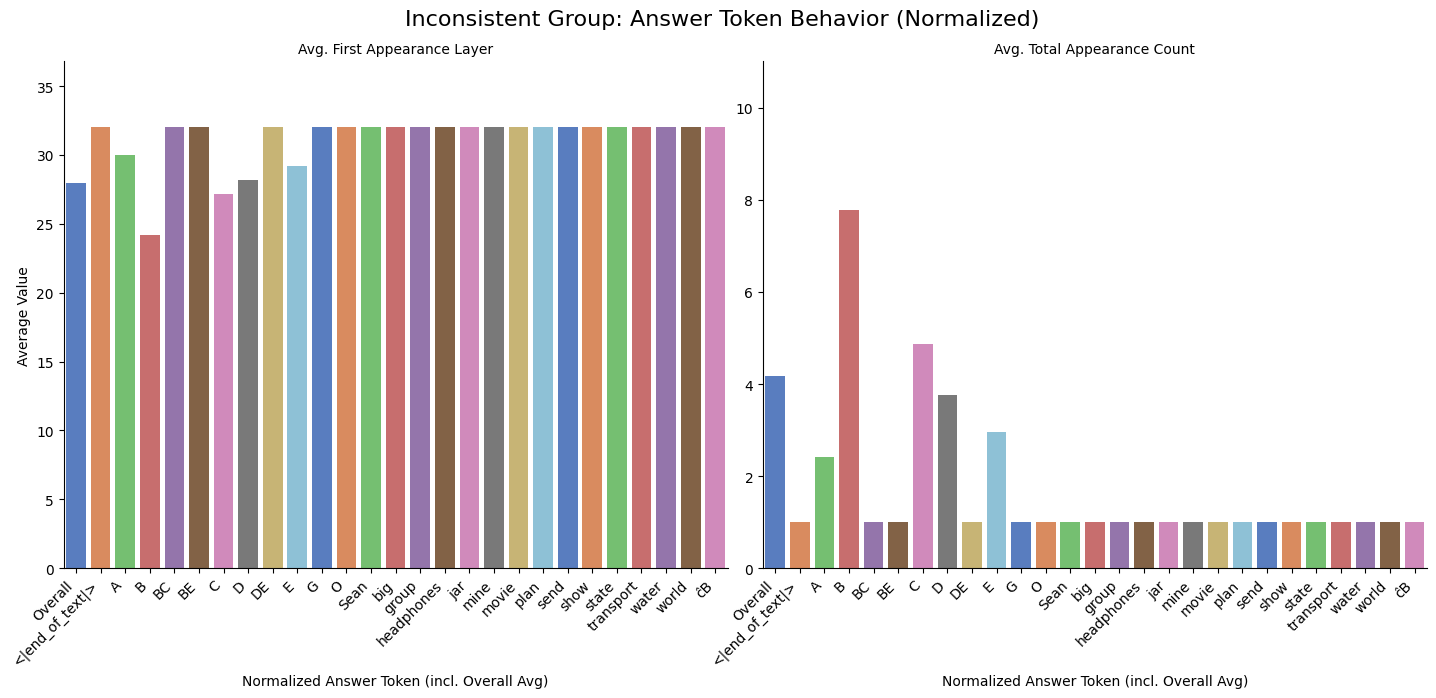

/tmp/ipython-input-4221016300.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_interest = sns.catplot(data=interest_data, x='target_token', y='Value', col='Metric', kind='bar', palette='coolwarm', sharey=False, height=6, aspect=1.2, order=interest_custom_order)


[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.1-8b/Figure/normalized_1_behavior_inconsistent_interest_only.png'


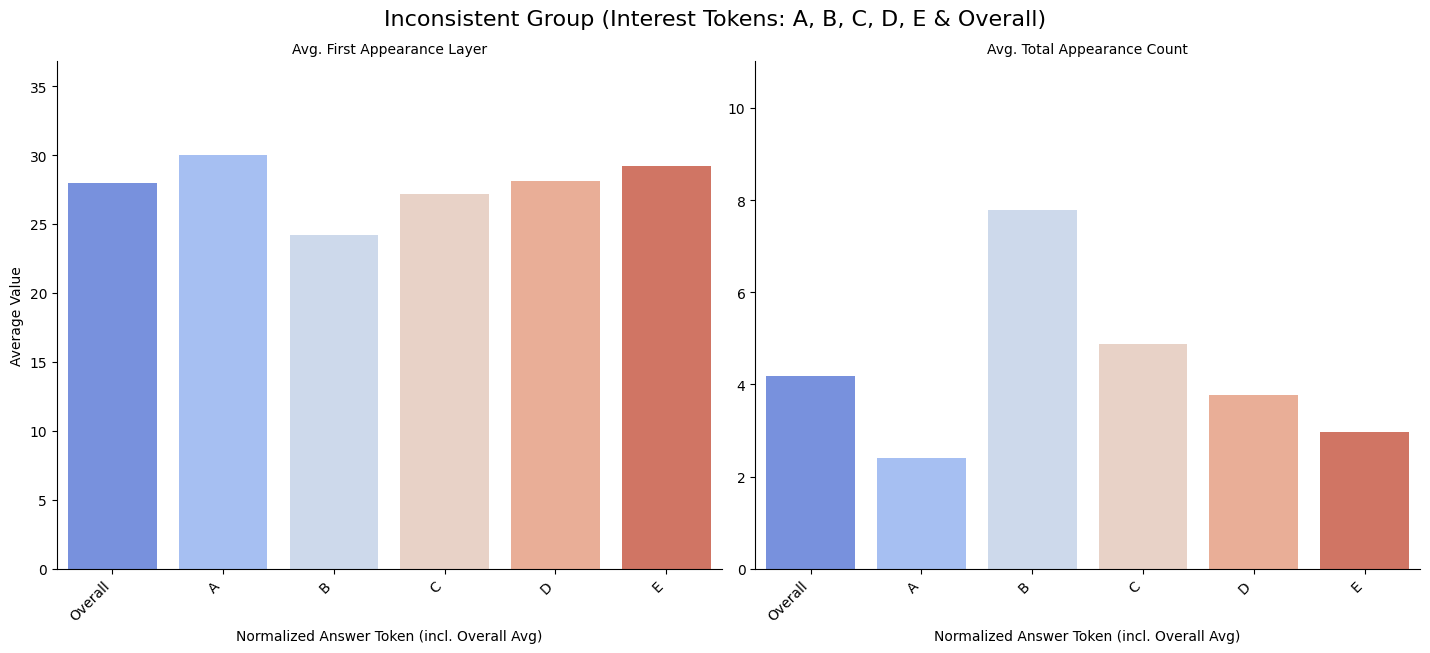



## 2. First Appearance Layer of Interest Tokens

[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.1-8b/Figure/normalized_2_interest_token_layer_distribution.png'


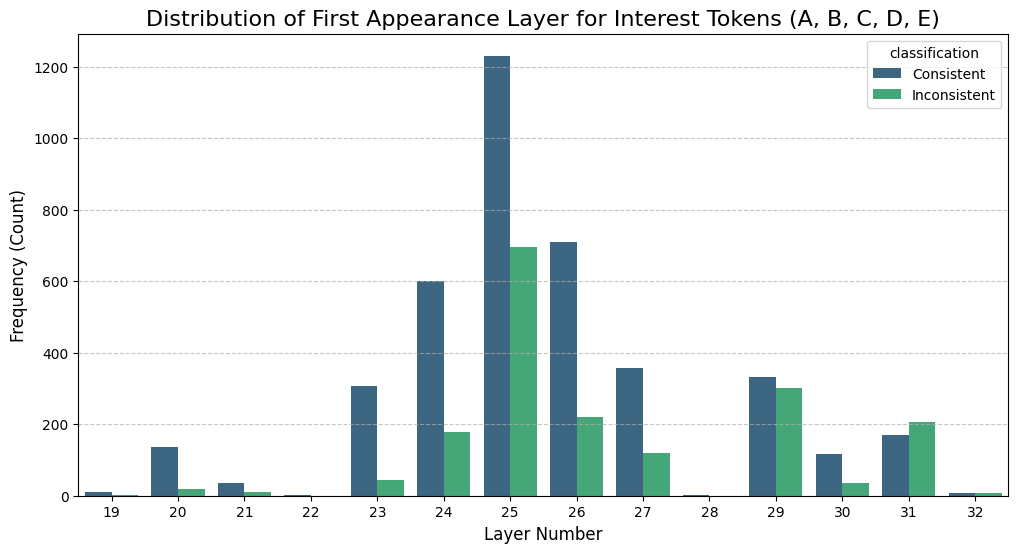



## 3. Group Distribution Comparison (Box Plots)

[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.1-8b/Figure/normalized_3_group_comparison_by_category_separated.png'


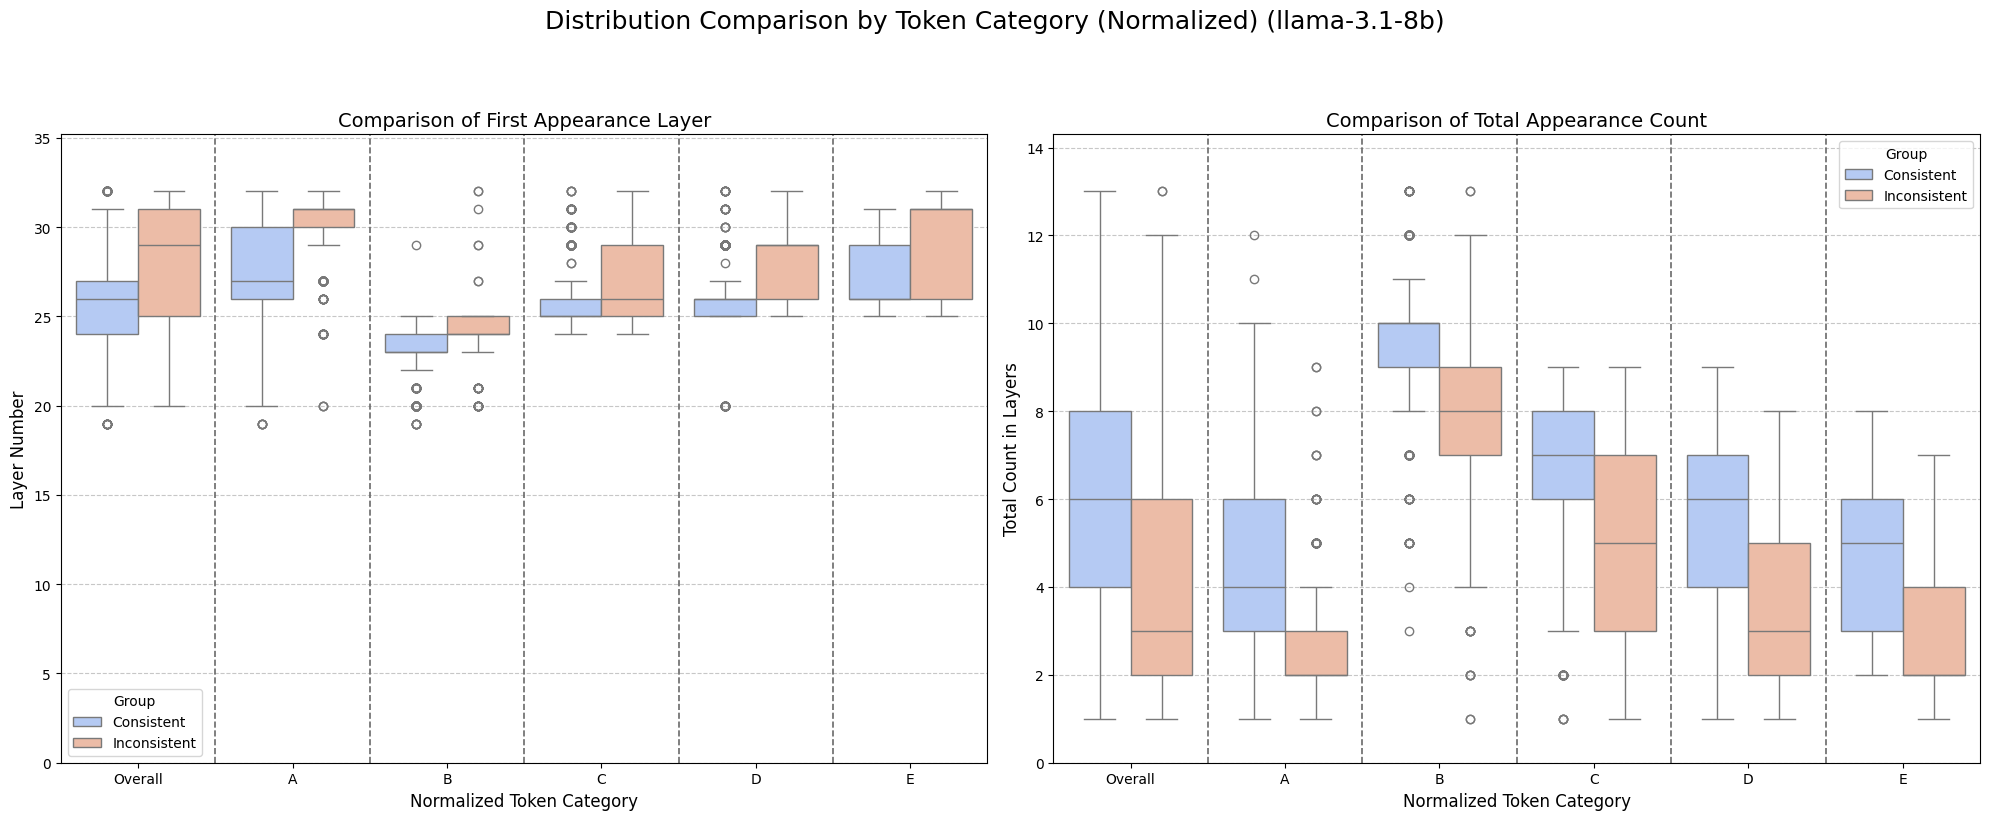

In [ ]:
# --- Main Execution Block ---
if __name__ == '__main__':

    save_directory = os.path.dirname(data_ilt_path)
    os.makedirs(os.path.join(save_directory, 'Figure'), exist_ok=True)

    try:
        with open(data_ilt_path, 'r', encoding='utf-8') as f:
            json_data = json.load(f)
        run_final_analysis(json_data, save_dir=save_directory, model_name=model_name)
    except FileNotFoundError:
        print(f"Error: '{data_ilt_path}' not found. Please check the file path and name.")
    except Exception as e:
        print(f"An error occurred: {e}")

# 2. Majority VS Minority

In [ ]:
import json
import os
import pandas as pd
from collections import Counter
from typing import Dict, Any, List, Set
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# --- 1. Normalization Function ---
def normalize_token(token: str) -> str:
    """Token normalization function to be used in all analyses."""
    # Removes 'Ċ' (line feed) and 'Ġ' (space) prefixes from the tokenizer.
    return token.strip('Ġ▁Ċ ')

# --- 2. Helper Functions ---
def analyze_answer_token_behavior(normalized_layer_predictions: List[str], normalized_target_token: str) -> Dict[str, Any]:
    """
    Analyzes the first appearance index and total frequency of a normalized target token
    within a list of normalized layer predictions.
    """
    if not normalized_layer_predictions:
        return {'first_index': None, 'count': None}
    indices = [i for i, token in enumerate(normalized_layer_predictions) if token == normalized_target_token]
    count = len(indices)
    if count == 0:
        return {'first_index': None, 'count': None}
    return {'first_index': indices[0], 'count': count}

def find_first_interest_layer(normalized_layer_predictions: List[str], normalized_interest_tokens: Set[str]) -> int | None:
    """Finds the first layer where an interest token (normalized) appears in the normalized layer predictions."""
    if not normalized_layer_predictions:
        return None
    for i, token in enumerate(normalized_layer_predictions):
        if token in normalized_interest_tokens:
            return i
    return None

def plot_answer_token_behavior_by_group(df: pd.DataFrame, interest_tokens: Set[str], save_dir: str):
    df_plot = df.dropna(subset=['first_index', 'count']).copy()
    if df_plot.empty: return

    df_plot['normalized_token'] = df_plot['target_token'].apply(normalize_token)
    stats_df = df_plot.groupby(['classification', 'normalized_token']).agg(
        avg_first_index=('first_index', 'mean'), avg_count=('count', 'mean')
    ).reset_index().rename(columns={'normalized_token': 'target_token'})
    overall_stats = df_plot.groupby('classification').agg(
        avg_first_index=('first_index', 'mean'), avg_count=('count', 'mean')
    ).reset_index()
    overall_stats['target_token'] = 'Overall'
    combined_stats = pd.concat([stats_df, overall_stats], ignore_index=True)
    if combined_stats.empty: return
    melted_df = combined_stats.melt(id_vars=['target_token', 'classification'], value_vars=['avg_first_index', 'avg_count'], var_name='Metric', value_name='Value')
    metric_map = {'avg_first_index': 'Avg. First Appearance Layer', 'avg_count': 'Avg. Total Appearance Count'}
    melted_df['Metric'] = melted_df['Metric'].replace(metric_map)
    max_layer_val = melted_df.loc[melted_df['Metric'] == 'Avg. First Appearance Layer', 'Value'].max()
    max_count_val = melted_df.loc[melted_df['Metric'] == 'Avg. Total Appearance Count', 'Value'].max()
    ylim_layer = (0, max_layer_val * 1.15) if pd.notna(max_layer_val) and max_layer_val > 0 else (0, 1)
    ylim_count = (0, max_count_val * 1.15) if pd.notna(max_count_val) and max_count_val > 0 else (0, 1)

    # Fix the groups to plot as 'Majority' and 'Minority'.
    plot_order = [group for group in ['Majority', 'Minority'] if group in df['classification'].unique()]

    for group in plot_order:
        group_data = melted_df[melted_df['classification'] == group]
        if group_data.empty: continue

        palette_setting = 'coolwarm' if group in ['Consistent', 'Majority'] else 'muted'
        unique_tokens = group_data['target_token'].unique()
        custom_order = ['Overall'] + sorted([t for t in unique_tokens if t != 'Overall'])
        g = sns.catplot(data=group_data, x='target_token', y='Value', col='Metric', kind='bar', palette=palette_setting, sharey=False, height=6, aspect=1.2, order=custom_order)
        g.fig.suptitle(f'{group} Group: Answer Token Behavior (Normalized)', y=1.03, fontsize=16)
        g.set_axis_labels("Normalized Answer Token (incl. Overall Avg)", "Average Value")
        g.set_titles(col_template="{col_name}")
        g.set_xticklabels(rotation=45, ha='right')
        for ax in g.axes.flat:
            title = ax.get_title()
            if 'Layer' in title: ax.set_ylim(ylim_layer)
            elif 'Count' in title: ax.set_ylim(ylim_count)
        filename = os.path.join(save_dir, "Figure", f"extended_1_behavior_{group.lower()}.png")
        plt.savefig(filename, bbox_inches='tight')
        print(f"[INFO] Plot saved to '{filename}'")
        plt.show(); plt.close()

def plot_interest_layer_distribution(df: pd.DataFrame, interest_tokens: Set[str], save_dir: str):
    df_plot = df.dropna(subset=['first_interest_layer']).copy()

    # Filter to keep only 'Majority' and 'Minority' data before plotting.
    df_plot = df_plot[df_plot['classification'].isin(['Majority', 'Minority'])]

    if df_plot.empty: return
    df_plot['first_interest_layer'] = df_plot['first_interest_layer'].astype(int)
    token_str = ', '.join(sorted(list(interest_tokens)))
    plt.figure(figsize=(12, 6))

    hue_order = [group for group in ['Majority', 'Minority'] if group in df_plot['classification'].unique()]
    sns.countplot(data=df_plot, x='first_interest_layer', hue='classification', palette='viridis', hue_order=hue_order)

    plt.title(f'Distribution of First Appearance Layer for Interest Tokens ({token_str})', fontsize=16)
    plt.xlabel('Layer Number', fontsize=12); plt.ylabel('Frequency (Count)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    filename = os.path.join(save_dir, "Figure", "extended_2_interest_token_layer_distribution.png")
    plt.savefig(filename, bbox_inches='tight')
    print(f"[INFO] Plot saved to '{filename}'")
    plt.show(); plt.close()

def plot_group_comparison_distributions(df: pd.DataFrame, normalized_interest_tokens: Set[str], save_dir: str, model_name: str = ""):
    df_plot = df.dropna(subset=['first_index', 'count', 'classification', 'target_token']).copy()

    # Filter to keep only 'Majority' and 'Minority' data before processing.
    df_plot = df_plot[df_plot['classification'].isin(['Majority', 'Minority'])]

    if df_plot.empty or not normalized_interest_tokens:
        print("[INFO] No Majority/Minority data available for group distribution comparison.")
        return

    df_plot['plot_category'] = df_plot['target_token'].apply(normalize_token)
    plot_categories = sorted(list(normalized_interest_tokens))
    dfs_to_concat = []
    overall_df = df_plot.copy()
    overall_df['plot_category'] = 'Overall'
    dfs_to_concat.append(overall_df)
    interest_data_df = df_plot[df_plot['plot_category'].isin(plot_categories)].copy()
    dfs_to_concat.append(interest_data_df)
    plotting_df = pd.concat(dfs_to_concat, ignore_index=True)
    category_order = ['Overall'] + plot_categories
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title_str = 'Distribution Comparison by Token Category (Normalized)' + (f' ({model_name})' if model_name else '')
    fig.suptitle(title_str, fontsize=18, y=1.02)
    y_max_layer = df_plot['first_index'].max()
    y_max_count = df_plot['count'].max()

    hue_order = [group for group in ['Majority', 'Minority'] if group in df_plot['classification'].unique()]

    sns.boxplot(ax=axes[0], data=plotting_df, x='plot_category', y='first_index', hue='classification', palette='coolwarm', order=category_order, hue_order=hue_order)
    axes[0].set_title('Comparison of First Appearance Layer', fontsize=14)
    axes[0].set_xlabel('Normalized Token Category', fontsize=12); axes[0].set_ylabel('Layer Number', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7); axes[0].legend(title='Group')
    axes[0].set_ylim(0, y_max_layer * 1.1 if pd.notna(y_max_layer) and y_max_layer > 0 else 1)
    sns.boxplot(ax=axes[1], data=plotting_df, x='plot_category', y='count', hue='classification', palette='coolwarm', order=category_order, hue_order=hue_order)
    axes[1].set_title('Comparison of Total Appearance Count', fontsize=14)
    axes[1].set_xlabel('Normalized Token Category', fontsize=12); axes[1].set_ylabel('Total Count in Layers', fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7); axes[1].legend(title='Group')
    axes[1].set_ylim(0, y_max_count * 1.1 if pd.notna(y_max_count) and y_max_count > 0 else 1)
    num_categories = len(category_order)
    for ax in axes:
        for i in range(num_categories - 1):
            ax.axvline(x=i + 0.5, color='dimgray', linestyle='--', linewidth=1.2)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    filename = os.path.join(save_dir, "Figure", "extended_3_group_comparison_by_category_separated.png")
    plt.savefig(filename, bbox_inches='tight')
    print(f"[INFO] Plot saved to '{filename}'")
    plt.show(); plt.close()

# --- 4. Main Analysis Execution Function ---
def run_final_analysis(data: Dict[str, Any], save_dir: str, model_name: str = "model"):
    """
    Classifies answer groups into 'Consistent', 'Inconsistent', 'Majority', 'Minority'
    and runs the analysis.
    """
    results = []
    for group_id, group_data in data.items():
        answers = group_data.get('answers', [])
        if not answers or len(answers) != 6: continue

        normalized_answers = [normalize_token(ans) for ans in answers]
        counts = Counter(normalized_answers)
        classifications = [''] * 6

        if len(counts) == 1:
            classifications = ['Consistent'] * 6
        else:
            max_freq = max(counts.values())
            tokens_with_max_freq = [token for token, freq in counts.items() if freq == max_freq]

            if len(tokens_with_max_freq) == 1 and max_freq in [4, 5]:
                majority_token = tokens_with_max_freq[0]
                classifications = ['Majority' if token == majority_token else 'Minority' for token in normalized_answers]
            else:
                classifications = ['Inconsistent'] * 6

        for i in range(len(answers)):
            prompt_key = f"Prompt_{i+1}"
            if prompt_key not in group_data: continue

            prompt_data = group_data[prompt_key]
            raw_target_token = answers[i]
            raw_layer_predictions = prompt_data.get('token', [])

            normalized_target_token = normalize_token(raw_target_token)
            normalized_layer_predictions = [normalize_token(p) for p in raw_layer_predictions]

            behavior_metrics = analyze_answer_token_behavior(normalized_layer_predictions, normalized_target_token)

            results.append({
                'classification': classifications[i], 'target_token': raw_target_token,
                'first_index': behavior_metrics['first_index'], 'count': behavior_metrics['count'],
                'layer_predictions': raw_layer_predictions
            })

    if not results:
        print("No data to analyze.")
        return

    df = pd.DataFrame(results)
    df['normalized_target_token'] = df['target_token'].apply(normalize_token)
    consistent_df = df[df['classification'] == 'Consistent']

    if not consistent_df.empty:
        interest_tokens = set(consistent_df['normalized_target_token'].unique())
        print(f"[INFO] Dynamically determined interest tokens: {sorted(list(interest_tokens))}")
    else:
        interest_tokens = set()
        print("[WARN] No 'Consistent' groups found. Interest token analysis will be skipped.")

    if interest_tokens:
        df['first_interest_layer'] = df['layer_predictions'].apply(
            lambda preds: find_first_interest_layer([normalize_token(p) for p in preds], interest_tokens)
        )
    else:
        df['first_interest_layer'] = None

    df = df.drop(columns=['layer_predictions', 'normalized_target_token'])

    print("\n" + "="*80)
    print(f"--- 📊 Final Analysis Report for {model_name} (Extended Classification) ---")
    print("="*80)
    print("\n## Data Points per Classification\n")
    print(tabulate(pd.DataFrame(df['classification'].value_counts()), headers=['Classification', 'Count'], tablefmt='grid'))

    print("\n\n## 1. Answer Token Behavior in Layers\n")
    df_base = df.dropna(subset=['first_index', 'count']).copy()
    if not df_base.empty:
        plot_answer_token_behavior_by_group(df_base, interest_tokens, save_dir)
    else:
        print("No data for answer token behavior analysis.")

    print("\n\n## 2. First Appearance Layer of Interest Tokens\n")
    if interest_tokens:
        df_interest = df.dropna(subset=['first_interest_layer']).copy()
        if not df_interest.empty:
            plot_interest_layer_distribution(df_interest, interest_tokens, save_dir)
        else:
            print("Interest tokens were not found in any layer predictions.")
    else:
        print("No interest tokens were defined (no consistent groups found).")

    print("\n\n## 3. Group Distribution Comparison (Box Plots)\n")
    if not df_base.empty:
        plot_group_comparison_distributions(df_base, interest_tokens, save_dir, model_name)
    else:
        print("Not enough data to generate group distribution comparison plots.")
    print("\n" + "="*80)

In [ ]:
dir_path = "./data"
dataset_name = "CommonsenseQA_test.jsonl"
model_name = "llama-3.1-8b"
dataset_path = dir_path + "/" + dataset_name
save_path = dir_path + "/" + model_name.lower()
data_ilt_path = dir_path + "/" + model_name.lower() + "/data_ilt.json"

[INFO] Dynamically determined interest tokens: ['A', 'B', 'C', 'D', 'E']

--- 📊 Final Analysis Report for llama-3.2-3b-instruct (Extended Classification) ---

## Data Points per Classification

+------------------+---------+
| Classification   |   Count |
+==================+=========+
| Consistent       |    4626 |
+------------------+---------+
| Majority         |     749 |
+------------------+---------+
| Inconsistent     |     252 |
+------------------+---------+
| Minority         |     235 |
+------------------+---------+


## 1. Answer Token Behavior in Layers



/tmp/ipython-input-1657066952.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=group_data, x='target_token', y='Value', col='Metric', kind='bar', palette=palette_setting, sharey=False, height=6, aspect=1.2, order=custom_order)


[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.2-3b-instruct/Figure/extended_1_behavior_majority.png'


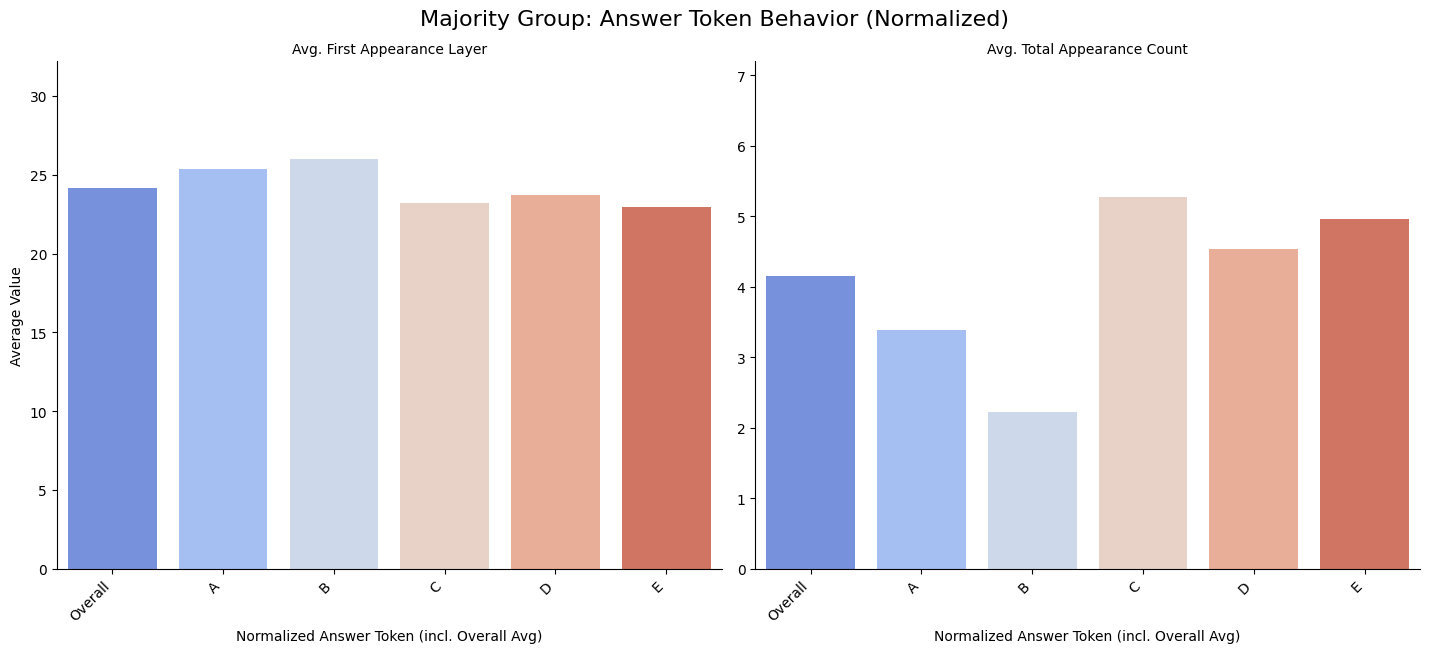

/tmp/ipython-input-1657066952.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=group_data, x='target_token', y='Value', col='Metric', kind='bar', palette=palette_setting, sharey=False, height=6, aspect=1.2, order=custom_order)


[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.2-3b-instruct/Figure/extended_1_behavior_minority.png'


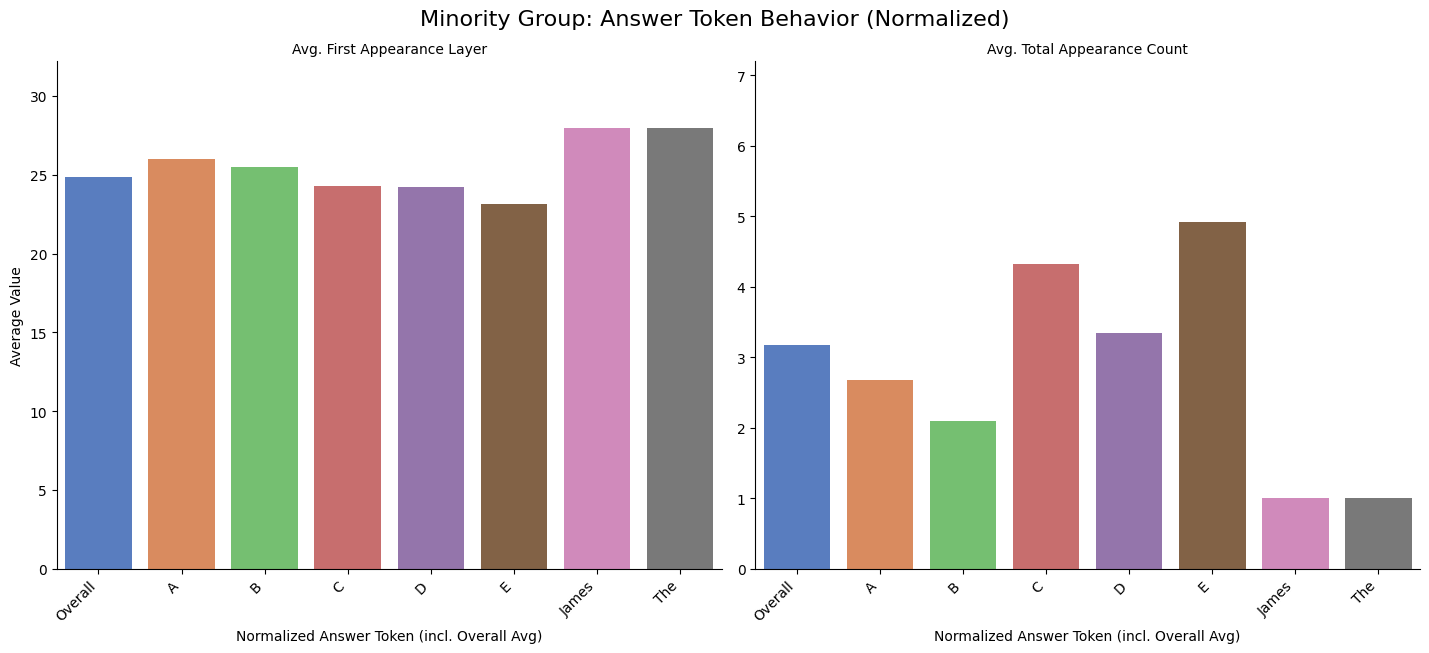



## 2. First Appearance Layer of Interest Tokens

[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.2-3b-instruct/Figure/extended_2_interest_token_layer_distribution.png'


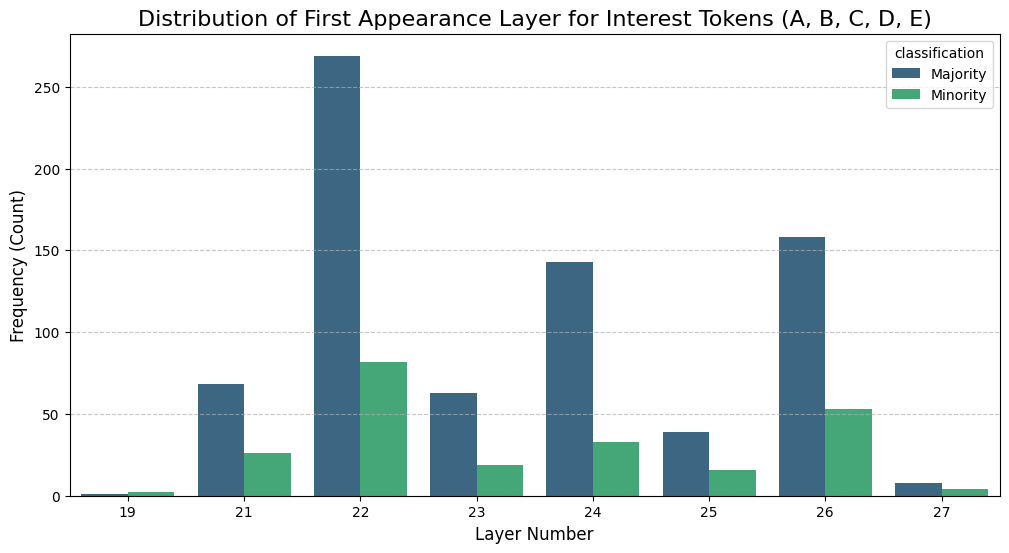



## 3. Group Distribution Comparison (Box Plots)

[INFO] Plot saved to '/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/llama-3.2-3b-instruct/Figure/extended_3_group_comparison_by_category_separated.png'


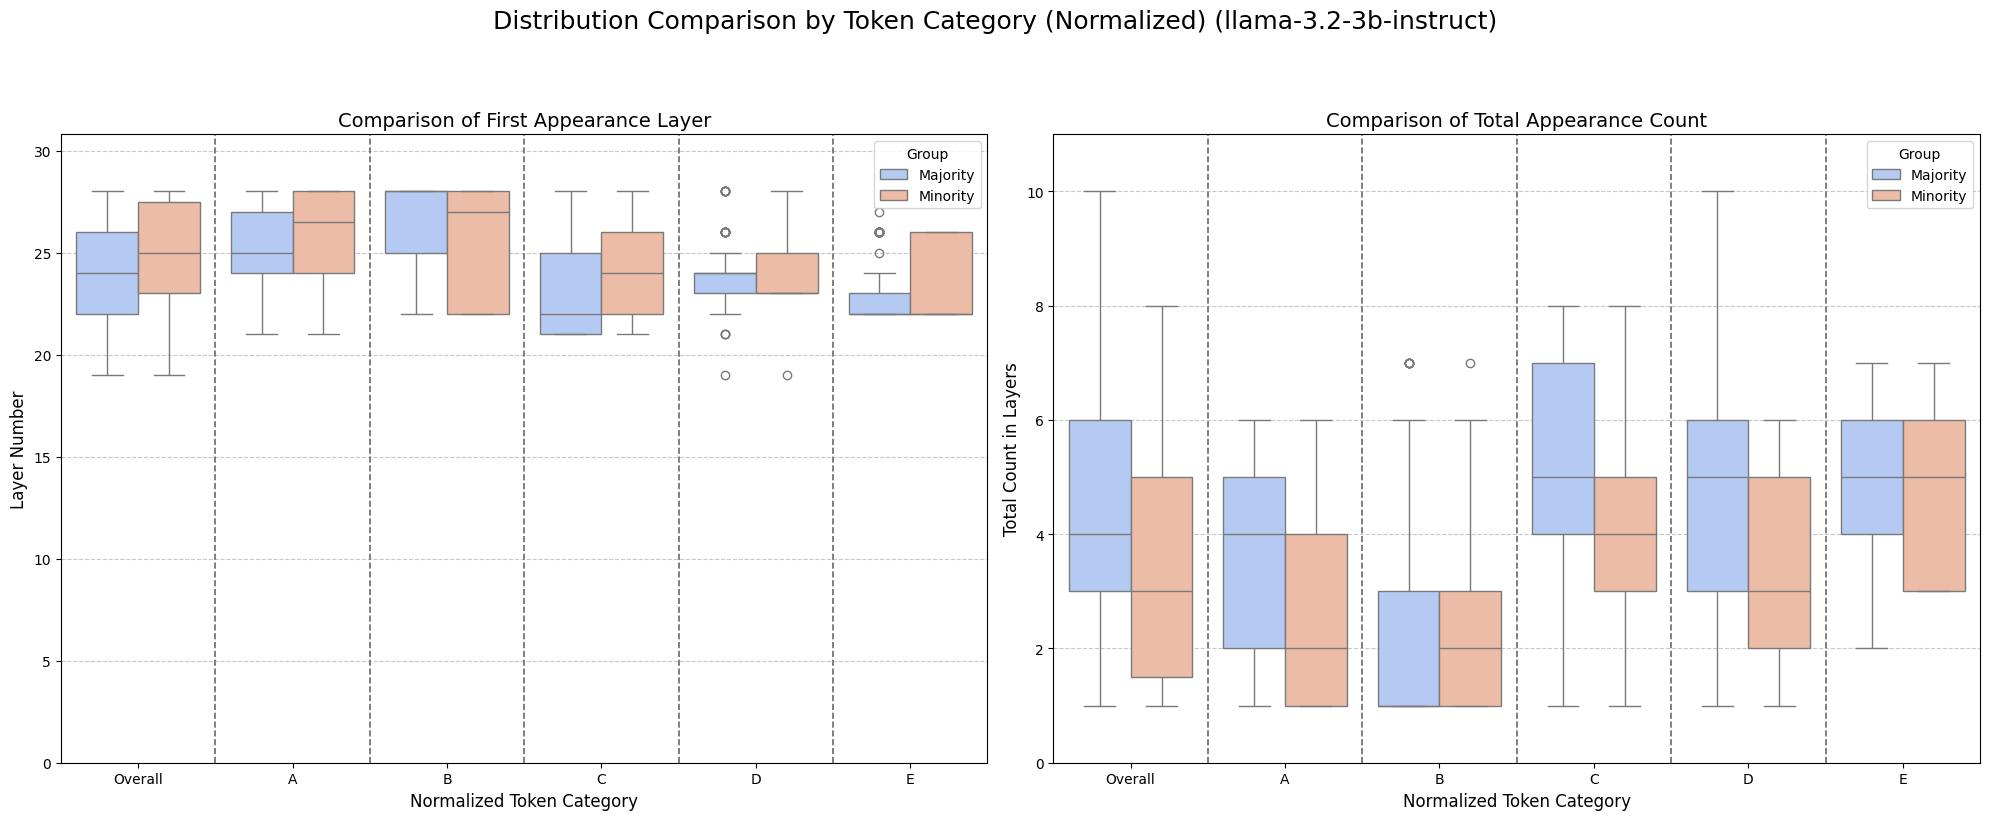

In [ ]:
# --- Main Execution Block ---
if __name__ == '__main__':

    # Ensure the 'Figure' directory exists within the save path
    os.makedirs(os.path.join(save_path, 'Figure'), exist_ok=True)

    try:
        # Open and load the JSON data file
        with open(data_ilt_path, 'r', encoding='utf-8') as f:
            json_data = json.load(f)

        # Run the main analysis function
        run_final_analysis(json_data, save_dir=save_path, model_name=model_name)

    except FileNotFoundError:
        print(f"Error: File not found at '{data_ilt_path}'. Please check the path.")
    except Exception as e:
        print(f"An error occurred during analysis: {e}")